In [337]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import matplotlib
from math import ceil
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from sklearn.metrics import precision_score,recall_score,classification_report
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

matplotlib.rcParams['figure.figsize'] = [16, 9]
sns.set()

In [357]:
def train_and_cv_models(X,y,nfolds=3,random_state=42,w2v=False):
    
    RS = random_state
    kf = KFold(n_splits=nfolds,shuffle=True,random_state=RS)
    
    if not w2v:
        print('Training NaiveBayes')

    model_nb = MultinomialNB()
    grid_search_nb = GridSearchCV(estimator=model_nb,
                              param_grid = {},
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=3,return_train_score=True)

    if not w2v:
        grid_search_nb.fit(X,y)
    
    print('Training LogisticRegression')
    log_reg_model = LogisticRegression(random_state=RS,solver='sag',n_jobs=-1)
    grid_search_logreg = GridSearchCV(estimator=log_reg_model,
                               param_grid={'C':[0.1,1,10]},
                               scoring='accuracy',
                               cv=kf,
                               n_jobs=-1,
                               verbose=3,return_train_score=True)
    grid_search_logreg.fit(X,y)
    
    print('Training SVM')
    svm_model = LinearSVC(random_state=RS)
    grid_search_svm = GridSearchCV(estimator=svm_model,
                              param_grid = {'C':[0.01,0.1,1,10,100]},
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=3,return_train_score=True)
    grid_search_svm.fit(X,y)

    print('Training XGB')

    model_xgb = XGBClassifier(random_state=RS,n_jobs=-1)
    grid_search_xgb = GridSearchCV(estimator=model_xgb,
                              param_grid = {'max_depth':[3],
                                           'n_estimators':[100],
                                           },
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=3,return_train_score=True)

    grid_search_xgb.fit(X,y)
    
    print('Training RandomForest')

    model_rf = RandomForestClassifier(random_state=RS,n_jobs=-1)
    grid_search_rf = GridSearchCV(estimator=model_rf,
                              param_grid = {'n_estimators':[50,100]},
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=3,return_train_score=True)

    grid_search_rf.fit(X,y)
    
    
    
    
    print('Training DecisionTree')

    model_dt = DecisionTreeClassifier(random_state=RS)
    grid_search_dt = GridSearchCV(estimator=model_dt,
                              param_grid = {'criterion':['gini','entropy']},
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=3,return_train_score=True)

    grid_search_dt.fit(X,y)
    
    
    
    print('Trained all models')
    
    model_dict = {'LOG_REG':grid_search_logreg,
              'SVM':grid_search_svm,
              'NB':grid_search_nb,
              'XGB':grid_search_xgb,
              'RF':grid_search_rf,   
              'DT':grid_search_dt}
    if w2v:
        del model_dict['NB']
    
    return model_dict

def eval_func(actual,prediction,roc=False,thresh=0.5):
    
    
    if roc:
        
        fpr, tpr, thresholds = roc_curve(actual, prediction)
        roc_auc = auc(tpr, fpr)

        
    prediction = prediction >= thresh
    prediction = prediction.astype(np.int)
        
    print('Accuracy = ',100*accuracy_score(actual,prediction))
    print('Confusion Matrix :')
    print(confusion_matrix(actual,prediction)*100/len(actual))
    
    if roc:
        plt.figure()
        plt.plot(tpr, fpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
    pass

### Part 1 ‑ Exploratory data analysis


The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [85]:
logins = pd.read_json('logins.json')

In [86]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
np.any(logins.isna())

False

In [6]:
logins.shape

(93142, 1)

In [7]:
logins.min()

login_time   1970-01-01 20:12:16
dtype: datetime64[ns]

In [8]:
logins.iloc[0]

login_time   1970-01-01 20:13:18
Name: 0, dtype: datetime64[ns]

In [9]:
(logins.max()-logins.min())

login_time   101 days 22:45:22
dtype: timedelta64[ns]

Aggregating on 15 Minutes

In [10]:
counts = logins.resample('15T',on='login_time').count()

In [11]:
counts.columns=['login_counts']

In [12]:
counts.head()

,login_counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


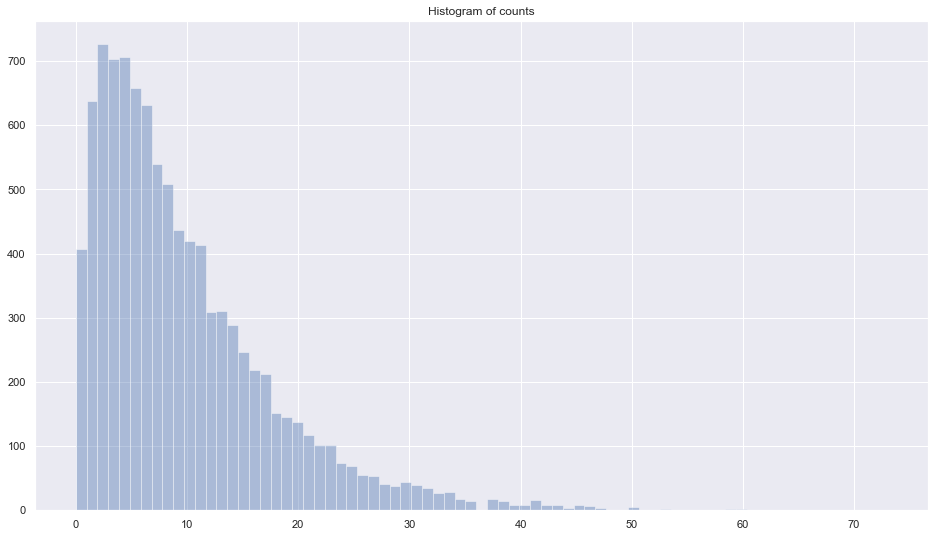

In [13]:
sns.distplot(counts,kde=False,bins=75);
plt.title('Histogram of counts');

Visualizing all data

C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


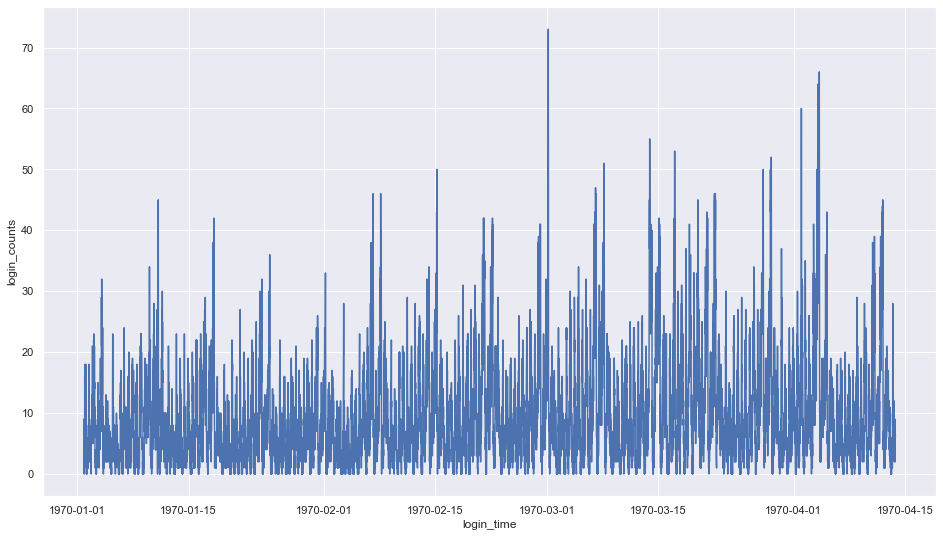

In [14]:
sns.lineplot(x='login_time',y='login_counts',data=counts.reset_index());

Visualizing over months

In [15]:
counts.reset_index(inplace=True)

In [16]:
counts['Month'] = counts.login_time.dt.month

In [17]:
month_col = {1:'red',2:'green',3:'blue',4:'orange'}

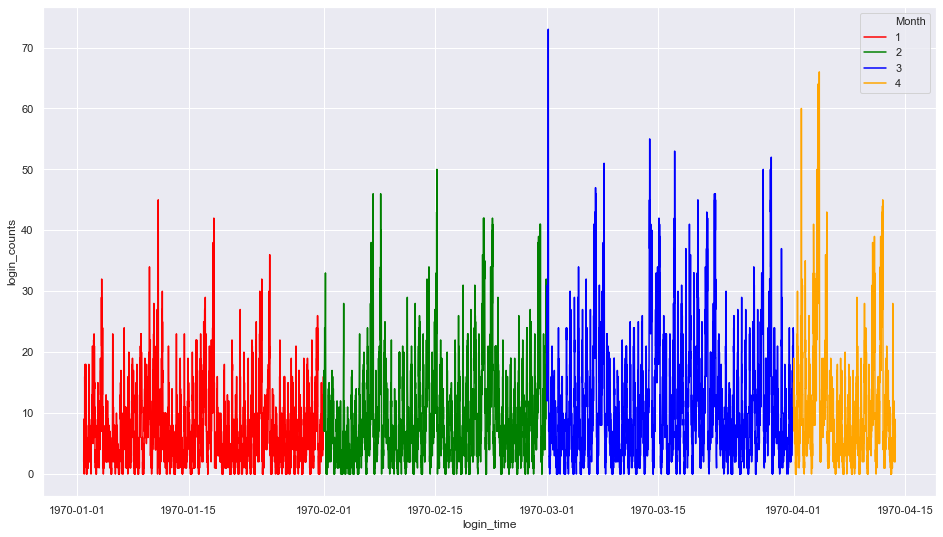

In [18]:
sns.lineplot(x='login_time',y='login_counts',hue='Month',palette = month_col,data=counts);

Observations:
    1. There is a cyclic trend across each month
    2. The counts peak in early march
    3. Half of April's data is provided


In [19]:
counts['date_ordinal'] = pd.to_datetime(counts.login_time).apply(lambda date: date.toordinal())

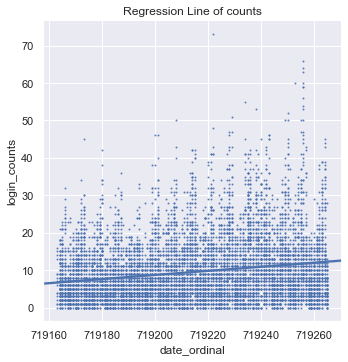

In [20]:
sns.lmplot(x='date_ordinal',y='login_counts',data=counts,scatter=True,scatter_kws={"s": 1});
plt.title('Regression Line of counts');

We can see that the overall login counts increase over time.

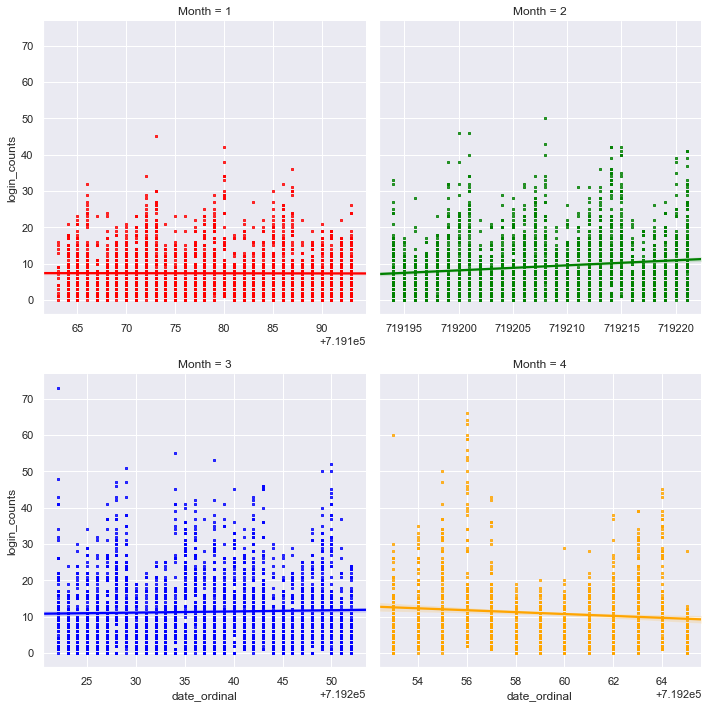

In [21]:
ax = sns.lmplot(
    data=counts,
    x='date_ordinal',
    y='login_counts',
    col='Month',
    col_wrap=2,
    palette = month_col,
    markers=',',
    hue='Month',
    sharex=False,
    scatter_kws={"s": 5})

Here we can see that for Jan and March, the trend is almost constant while in Feb and Apr its increasing and decreasing respectively

Lets convert the time stamps to hourly so that the analysis can be generalized over the hours of the day.

In [22]:
counts_hour = logins.resample('1H',on='login_time').count()


In [23]:
counts_hour.columns = ['counts']

In [24]:
counts_hour.head()

,counts
login_time,
1970-01-01 20:00:00,24
1970-01-01 21:00:00,9
1970-01-01 22:00:00,21
1970-01-01 23:00:00,58
1970-01-02 00:00:00,53


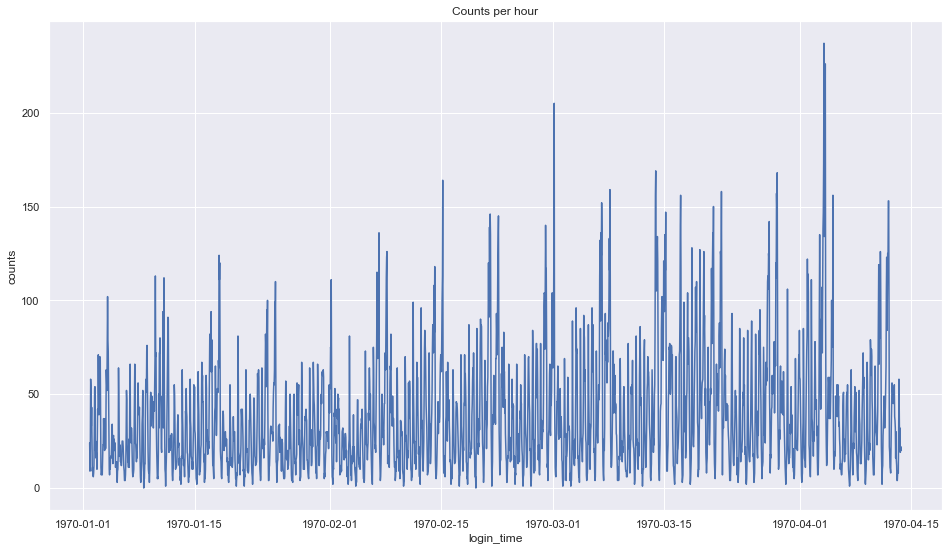

In [25]:
sns.lineplot(x='login_time',y='counts',data=counts_hour.reset_index());
plt.title('Counts per hour');

 Before doing further analysis i would want to extract some date features from the data

In [26]:
def create_date_features(df):
    df['month'] = df.index.month
    df['weekofyear'] = df.index.weekofyear
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    def week_of_month(dt):
        
        """ Returns the week of the month for the specified date.
        """

        first_day = dt.replace(day=1)

        dom = dt.day
        adjusted_dom = dom + first_day.weekday()

        return int(ceil(adjusted_dom/7.0))
    
    df['weekofmonth'] = df.index.map(week_of_month)
    return df

In [27]:
count_ext = create_date_features(counts_hour)

In [28]:
count_ext['IsWeekend'] = np.where(count_ext.weekday.isin([5,6]) ,True,False)

In [29]:
night_mask_fri = np.where((count_ext.weekday == 4) & (count_ext.hour.isin([20,21,22,23])),True,False)
nigh_mask_sat = np.where((count_ext.weekday == 5) & (count_ext.hour.isin([20,21,22,23,0,1,2,3])),True,False)
night_mask_sun = np.where((count_ext.weekday == 6) & (count_ext.hour.isin([0,1,2,3])),True,False)

In [30]:
night_mask = night_mask_fri | nigh_mask_sat | night_mask_sun

In [31]:
count_ext['WeekendOrNightlife'] = np.where(night_mask,'Nightlife',np.where(count_ext.IsWeekend ,'Weekend','NoWeekend'))

In [32]:
count_ext.WeekendOrNightlife.value_counts()

NoWeekend    1667
Weekend       540
Nightlife     240
Name: WeekendOrNightlife, dtype: int64

In [33]:
count_ext.IsWeekend.value_counts()

False    1727
True      720
Name: IsWeekend, dtype: int64

Add Nightlife trends are usually from 8 pm to 3 am on Friday and Saturday and early hours of sunday

Daily plot of mean_counts aggregated over day and hour

In [39]:
col = {'Nightlife':'red','Weekend':'orange','NoWeekend':'blue'}

In [57]:
?sns.countplot

C:\Users\shahb\AnacondaPython\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\shahb\AnacondaPython\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


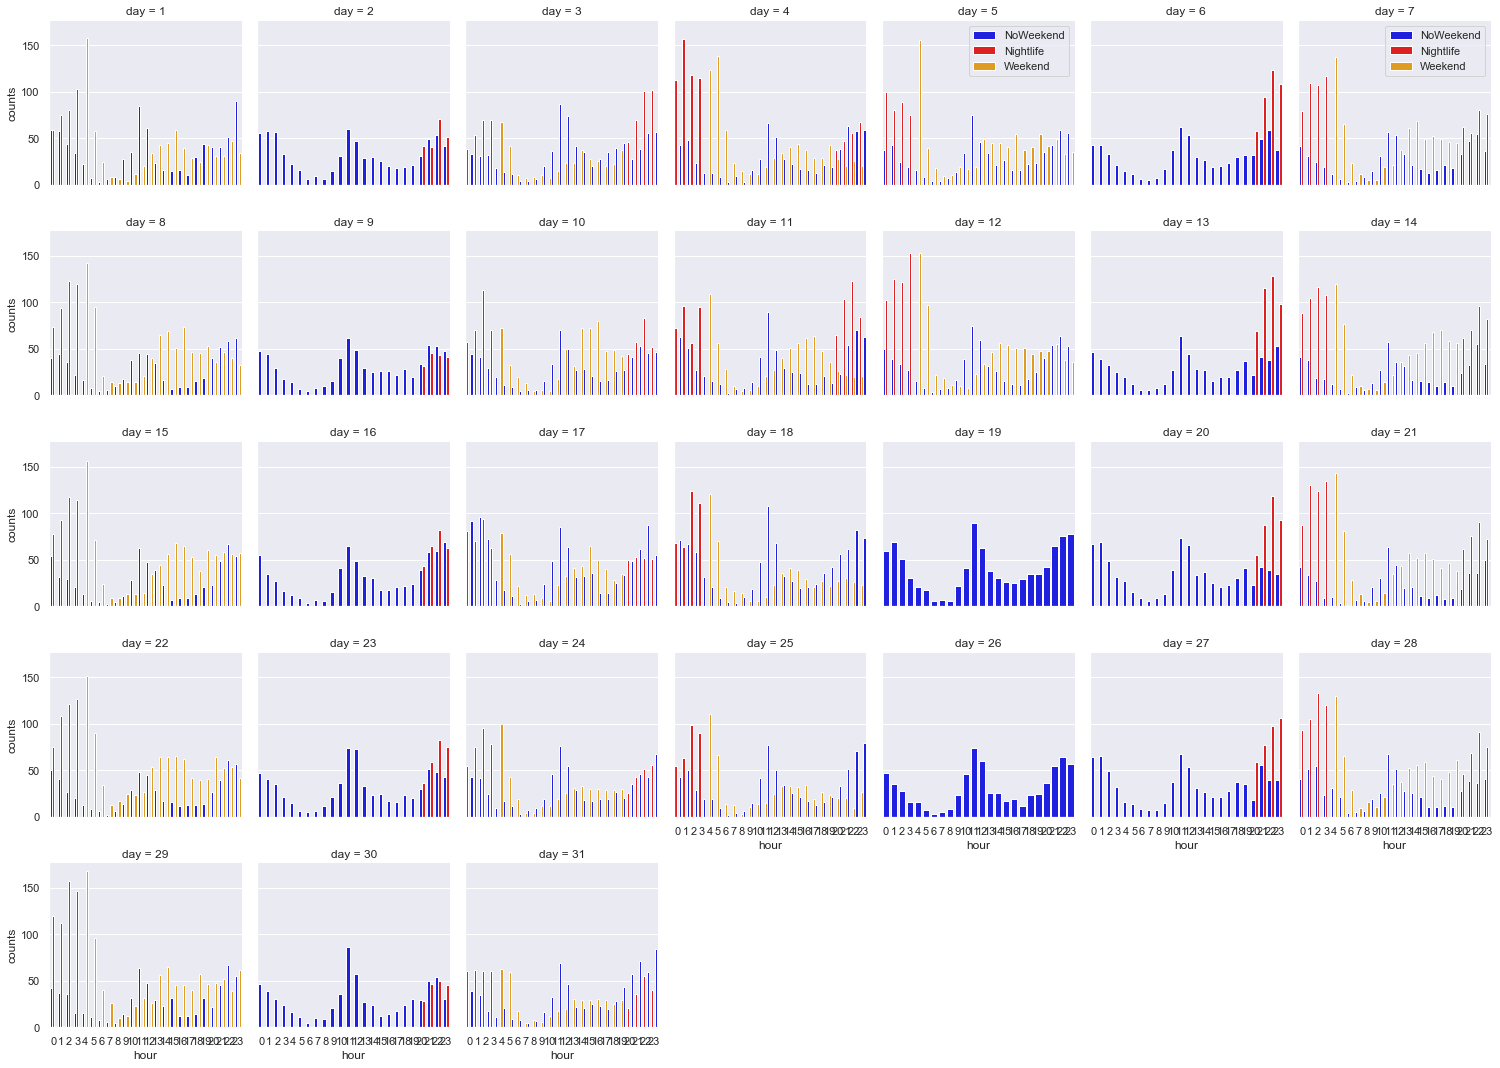

In [62]:
g = sns.FacetGrid(count_ext[['day','hour','counts','WeekendOrNightlife']],col='day',col_wrap=7,margin_titles=True)
g.map(sns.barplot,'hour','counts','WeekendOrNightlife',palette=col,ci=None);
g.axes[6].legend()
g.axes[4].legend()

Observations

1. General trend of the logins remains constant across the month.
2. The highest login counts are in the early hours of the days for days 1-4
3. For day 5 the counts peak during midday - This can be because a lot of people would be leaving offices early on fridays. The counts again increase after 08PM, possibly due to nightlife on friday night.
4. For days 5 and 6 - the counts peak from 10AM till 2PM. These are fridays and saturdays so people would want to go out in the afternoons.
5. Counts increase and remain high for the late hours of day 6 and early hours of day 7. This looks like the nightlife activities.

### Part 2: Experiment and metrics design
_The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities._

_However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs._

_What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
how you will implement the experiment.
what statistical test(s) you will conduct to verify the significance of the observation.
how you would interpret the results and provide recommendations to the city operations team along with any caveats._

###  Solution
Our objective here is to encourage drivers to serve both cities, which means that we want the drivers to spend an equal proportion of time in both cities. So our metric should be the difference of the percentage times spent in each city. We should get a near zero value for the difference if the driver is spending and equal amount to time in each city.


We would run the experiment for a sample of the drivers and incentivise only 50% of them. The experiment should be conducted at even times, even days and even seasons. There might be other factors in play as well e.g. the drivers might want to stay in his/her home city on the weekday or on the weekend. The season might also influence this metric. So the experiment should be conducted to normalize for these.

The NULL hypothesis of the experiment would be that the incentive has no effect on our metric. i.e. the difference in the means of the differences of the percentage times spent in each city is zero. We can then conduct a one sided z-test (assuming that the sample size would be large enough.) to verify if there is a difference the means of both groups.

One sided because we are not concerned with whether the shift occured only for one city. We want to see the overall effect so we should not be concerned with the sign of the difference.

In [99]:
file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [100]:
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
ultimate_black_user          bool
weekday_pct               float64
dtype: object

In [101]:
df['last_trip_date']=pd.to_datetime(df['last_trip_date'])
df['signup_date']=pd.to_datetime(df['signup_date'])

In [131]:
df.describe(include='all')

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000,50000,49604,50000,50000.000000,50000.000000,50000,50000.000000
unique,NaN,NaN,NaN,NaN,3,182,2,31,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,Winterfell,2014-06-29 00:00:00,iPhone,2014-01-18 00:00:00,NaN,NaN,False,NaN
freq,NaN,NaN,NaN,NaN,23336,2036,34582,2948,NaN,NaN,31146,NaN
first,NaN,NaN,NaN,NaN,NaN,2014-01-01 00:00:00,NaN,2014-01-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2014-07-01 00:00:00,NaN,2014-01-31 00:00:00,NaN,NaN,NaN,NaN
mean,5.796827,4.778158,4.601559,1.074764,NaN,NaN,NaN,NaN,8.849536,2.278200,NaN,60.926084
std,5.707357,0.446652,0.617338,0.222336,NaN,NaN,NaN,NaN,19.958811,3.792684,NaN,37.081503
min,0.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000
25%,2.420000,4.700000,4.300000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,33.300000


We can see that the data belongs to users who signed up in January of 2014 and took their last trip on 01 July 2014

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [107]:
df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

We see above that the maximum value taken by the **last_trip_date** column is 2014-07-01. We can assume that this would be the comparison date for the 30 days.

In [140]:
df['retained'] = (pd.to_datetime('2014-07-01') - df['last_trip_date']) > pd.to_timedelta('30d')

In [145]:
print('Percentage retained : ',np.mean(df.retained)*100)

Percentage retained :  62.392


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
retained                  50000 non-null bool
dtypes: bool(2), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.3+ MB


In [148]:
for column in list(df.columns):
    num_missing = len(df[df[column].isnull()])
    if num_missing != 0:
        print('There are {} missing values in {}'.format(num_missing, column))

There are 201 missing values in avg_rating_by_driver
There are 8122 missing values in avg_rating_of_driver
There are 396 missing values in phone


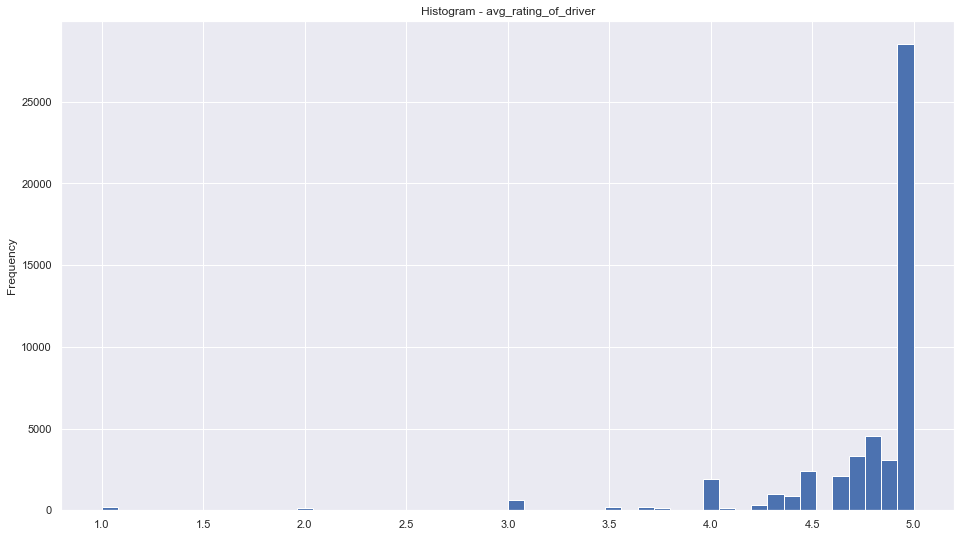

In [189]:
(df[~df['avg_rating_by_driver'].isnull()].avg_rating_by_driver).plot(kind='hist',bins=50)
plt.title('Histogram - avg_rating_of_driver');

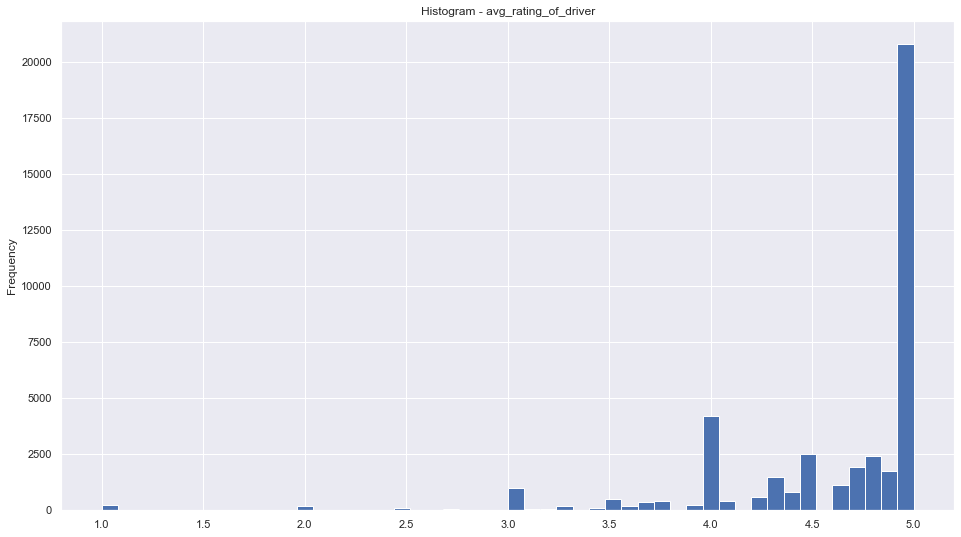

In [188]:
(df[~df['avg_rating_of_driver'].isnull()].avg_rating_of_driver).plot(kind='hist',bins=50)
plt.title('Histogram - avg_rating_of_driver');

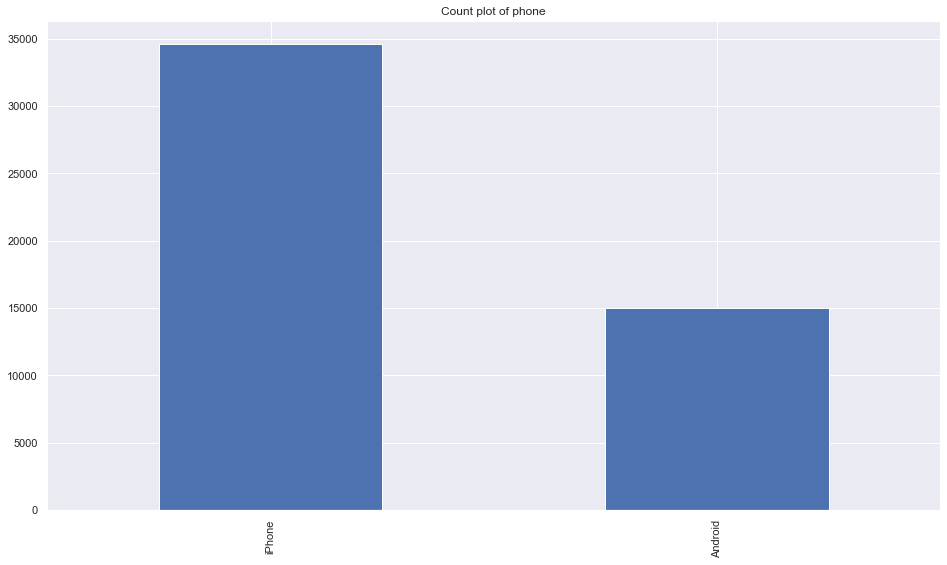

In [187]:
(df[~df.phone.isnull()]['phone'].value_counts()).plot(kind='bar')
plt.title('Count plot of phone');

For phone and avg_rating_by_driver imputing the missing value with the mode and the mean makes sense because the distributions are skewed AND the missing entries are just a handful

For avg_rating_of driver, using the mean would be a naive approach since about 20% of these values are missing and the mean might not be an exact representative of the data. For now we will use the mean, in the interest of time.

In [190]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna('iPhone', inplace=True)

In [200]:
numerical_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                      'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']

categorical_features = ['city', 'phone', 'ultimate_black_user']

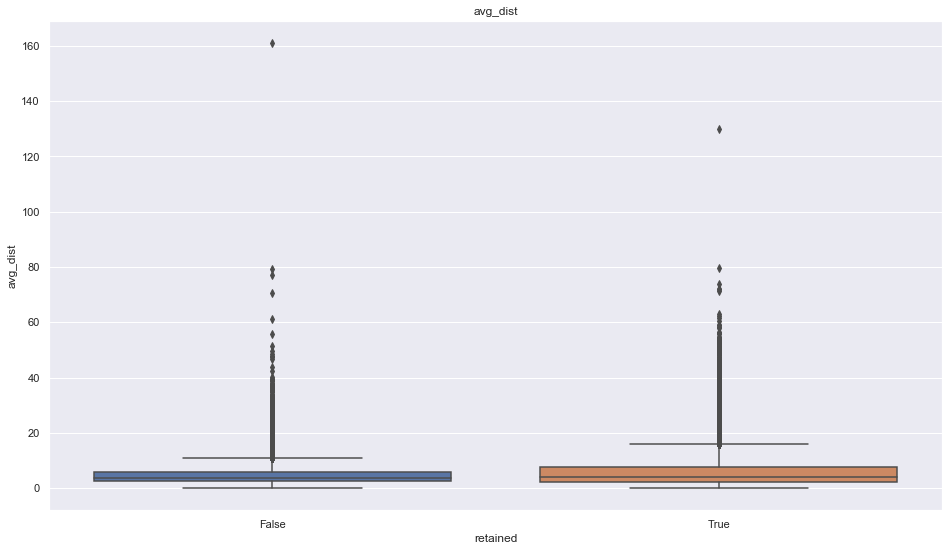

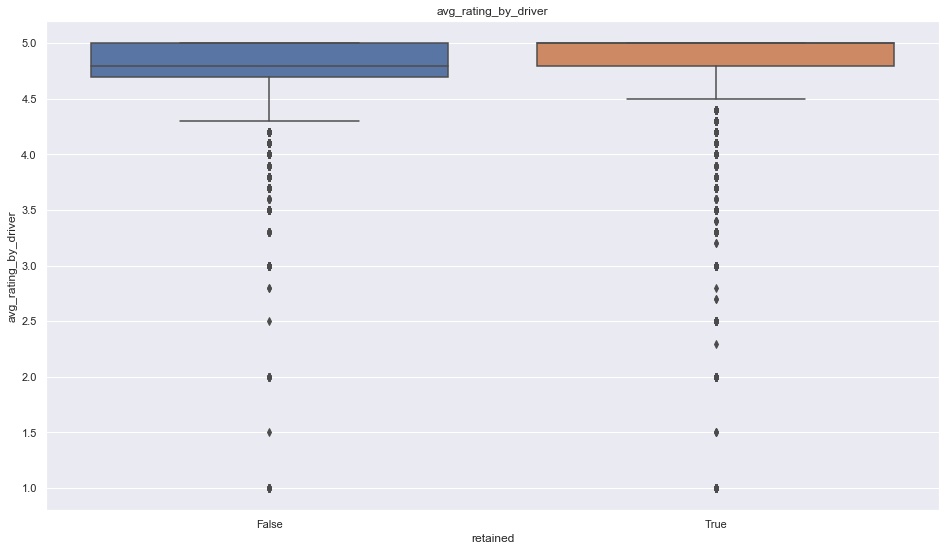

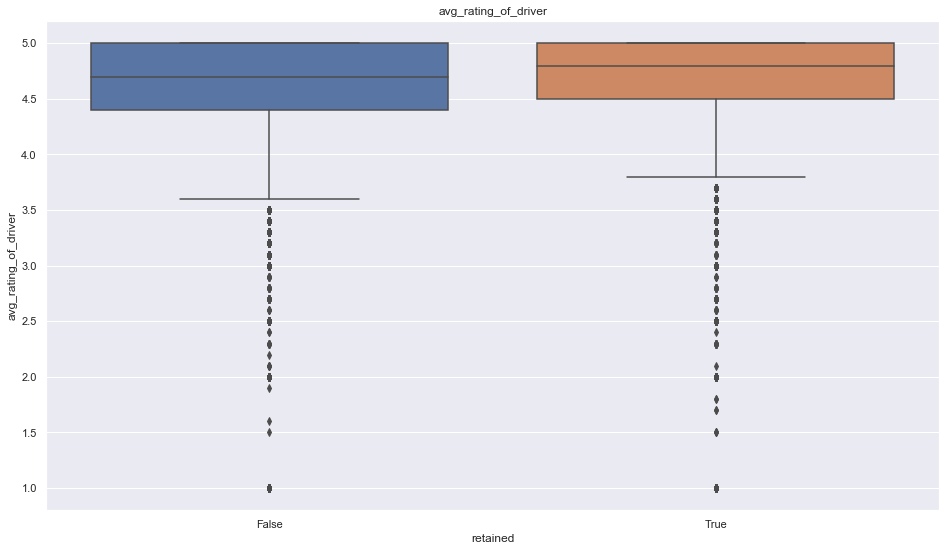

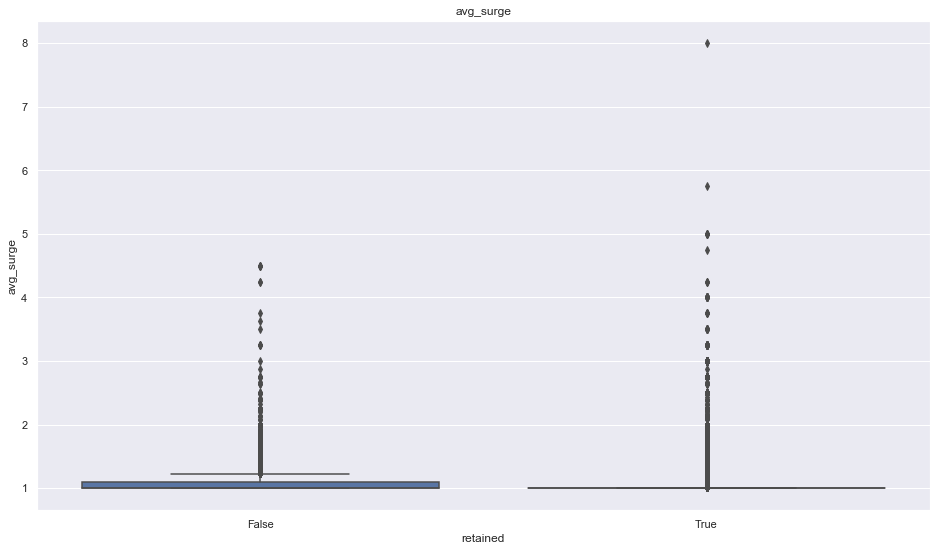

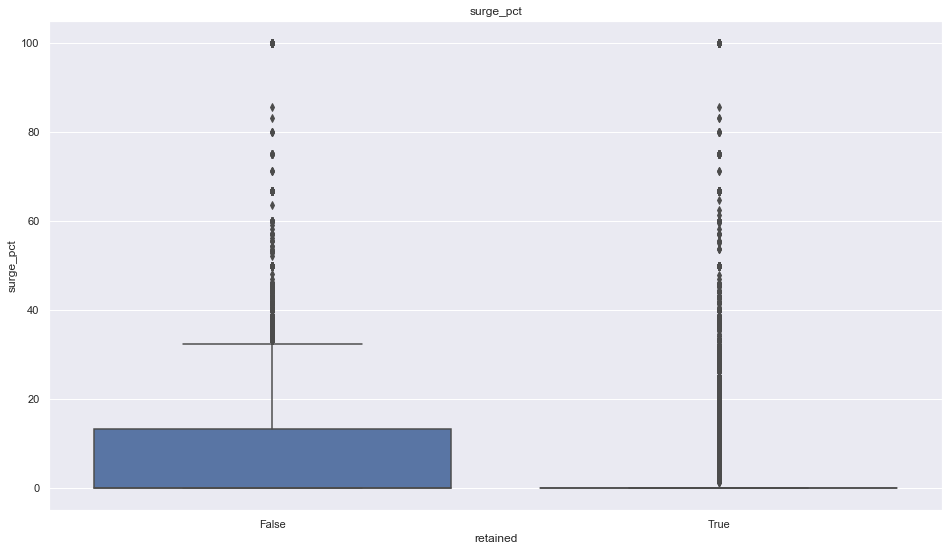

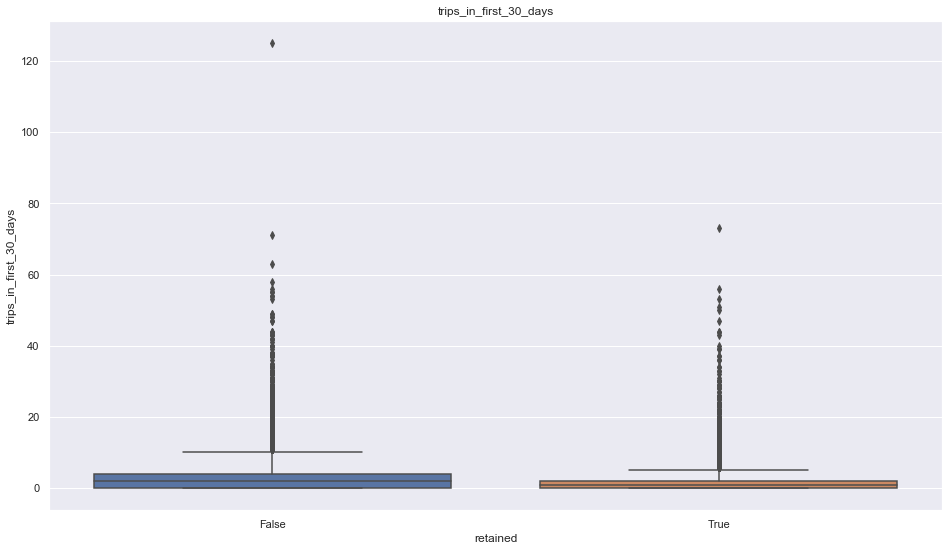

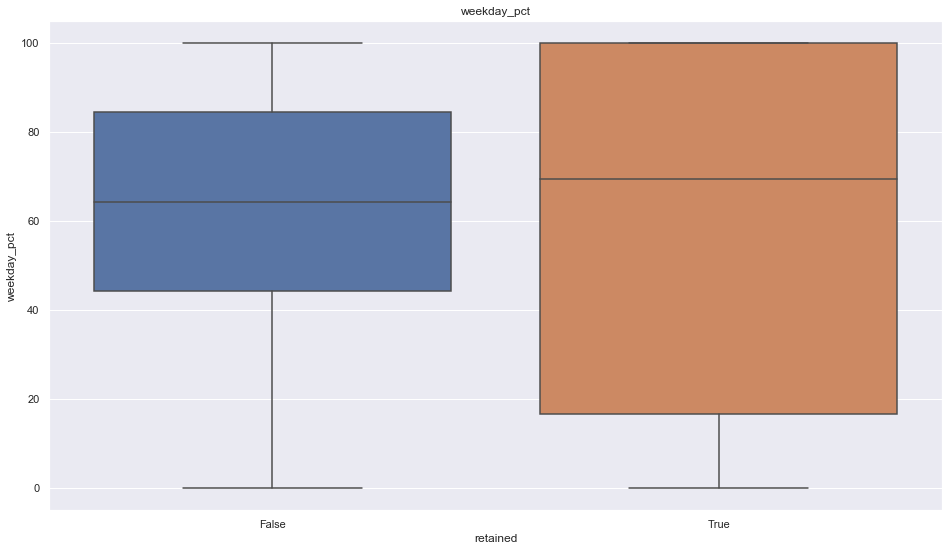

In [213]:
for feature in numerical_features:
    sns.boxplot(y=feature,x='retained',data=df,orient='v');
    plt.title(feature)
    plt.show();

In [212]:
df.retained.value_counts()/len(df)

True     0.62392
False    0.37608
Name: retained, dtype: float64

These are very interesting insights. from the graphs above users who retianed
    1. travelled longer
    2. The drivers liked them more
    3. They liked the drivers more
    4. Saw less of avg_surge
    5. the non_retained users saw immense pct_surges.
    6. The non-retained ones used it more often in the first 30 days of signing than the retained ones.
    7. retained users use the servise slightly more over the weekdays


In [224]:
?sns.countplot

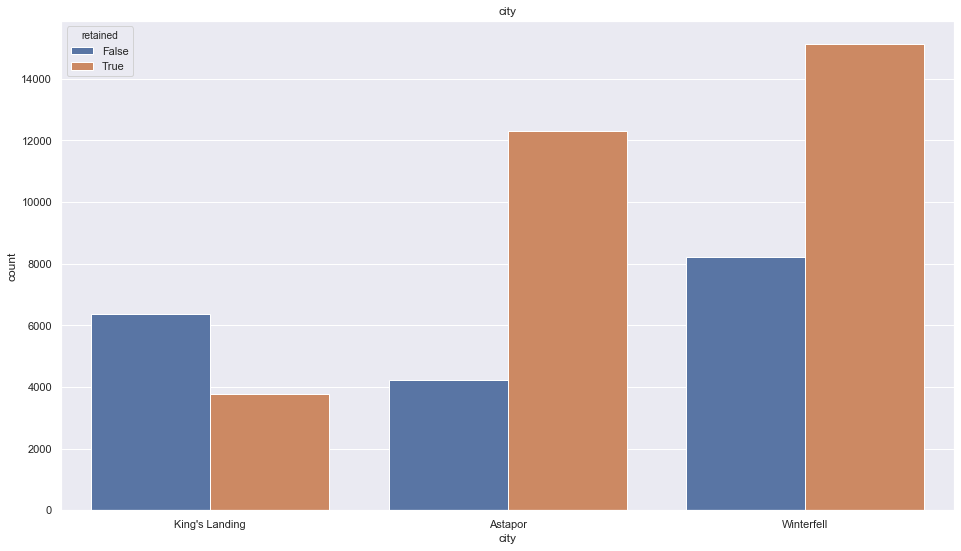

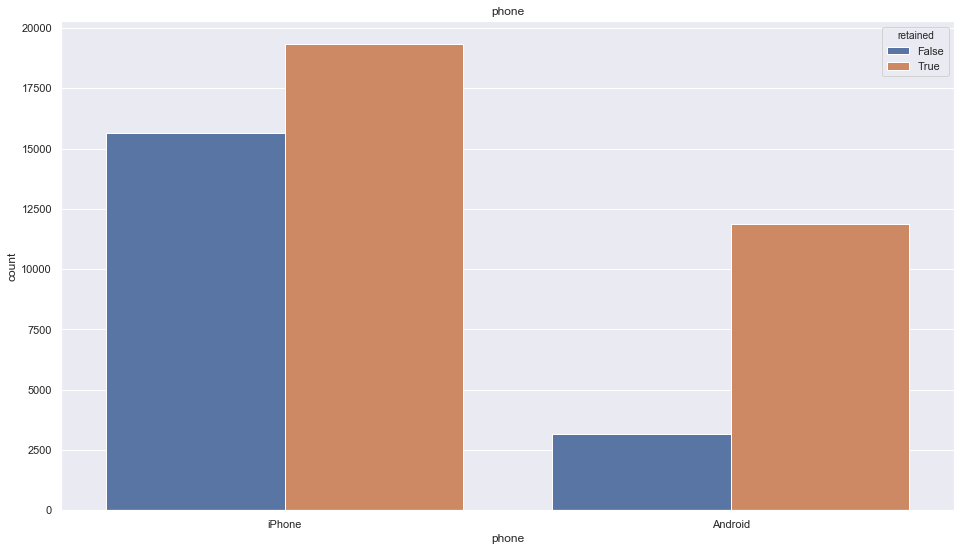

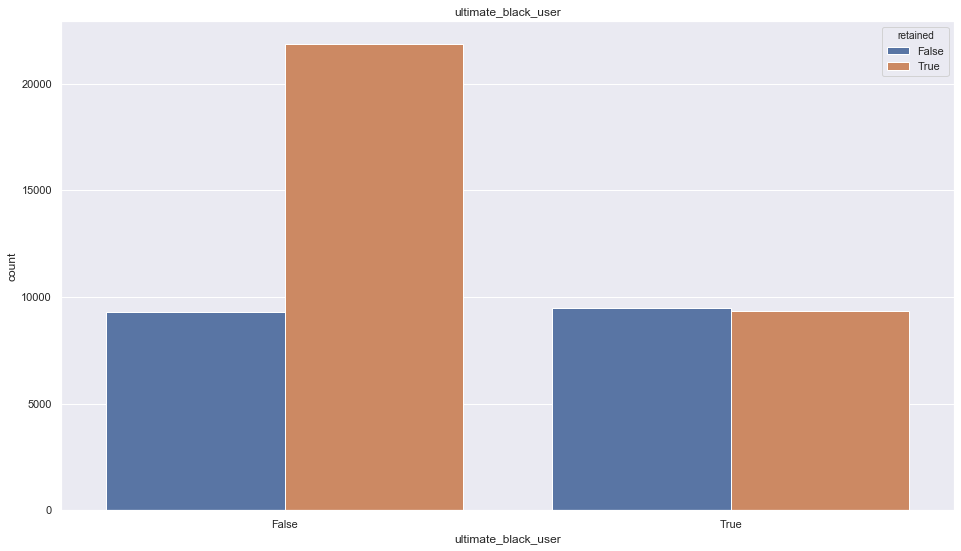

In [223]:
for feature in categorical_features:
    sns.countplot(x=feature,hue='retained',data=df);
    plt.title(feature);
    plt.show()

Observations

1. We can see that users from Kings Landing are retained less as compared to other cities
2. black user tend to get retained more.
3. Proportionally, Android users retain more

### Modeling

In [280]:
df_model = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])

In [281]:
df_model.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,46.2,False,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,50.0,True,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,100.0,True,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,80.0,False,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,82.4,True,0,0,1,1,0,1,0


last_trip_date has to be dropped since our target feature 'retained' is derived from that.

In [282]:
df_model.drop('last_trip_date',axis=1,inplace=True)

In [283]:
df_model.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,signup_date,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,2014-01-25,15.4,4,46.2,False,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,2014-01-29,0.0,0,50.0,True,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,2014-01-06,0.0,3,100.0,True,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,2014-01-10,20.0,9,80.0,False,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,2014-01-27,11.8,14,82.4,True,0,0,1,1,0,1,0


In [284]:
df_model['signup_days'] = [delta.days for delta in (df.signup_date - df.signup_date.min())]

In [285]:
df_model.drop(['signup_date'],axis=1,inplace=True)

In [286]:
df_model.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True,signup_days
0,3.67,5.0,4.7,1.10,15.4,4,46.2,False,0,1,0,0,1,0,1,24
1,8.26,5.0,5.0,1.00,0.0,0,50.0,True,1,0,0,1,0,1,0,28
2,0.77,5.0,4.3,1.00,0.0,3,100.0,True,1,0,0,0,1,1,0,5
3,2.36,4.9,4.6,1.14,20.0,9,80.0,False,0,1,0,0,1,0,1,9
4,3.13,4.9,4.4,1.19,11.8,14,82.4,True,0,0,1,1,0,1,0,26


In [323]:
y = np.where(df_model.retained,1,0)
X = df_model.drop('retained',axis=1)

In [324]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

In [325]:
df_model.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True,signup_days
0,3.67,5.0,4.7,1.10,15.4,4,46.2,False,0,1,0,0,1,0,1,24
1,8.26,5.0,5.0,1.00,0.0,0,50.0,True,1,0,0,1,0,1,0,28
2,0.77,5.0,4.3,1.00,0.0,3,100.0,True,1,0,0,0,1,1,0,5
3,2.36,4.9,4.6,1.14,20.0,9,80.0,False,0,1,0,0,1,0,1,9
4,3.13,4.9,4.4,1.19,11.8,14,82.4,True,0,0,1,1,0,1,0,26


In [326]:
log_reg = LogisticRegression(max_iter=500,n_jobs=-1)

cv_logreg = GridSearchCV(estimator=log_reg,
                        param_grid = {'C':[0.01,0.1,1,10]},
                        scoring='accuracy',
                        return_train_score=True,
                        cv=KFold(n_splits=3,random_state=42),
                         verbose=3
                        )
cv_logreg.fit(X_train,y_train)

C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=0.01 ..........................................................
[CV] .......... C=0.01, score=(train=0.717, test=0.719), total=   7.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV] .......... C=0.01, score=(train=0.717, test=0.717), total=   7.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s


[CV] .......... C=0.01, score=(train=0.719, test=0.717), total=   6.0s
[CV] C=0.1 ...........................................................
[CV] ........... C=0.1, score=(train=0.717, test=0.718), total=   5.8s
[CV] C=0.1 ...........................................................
[CV] ........... C=0.1, score=(train=0.717, test=0.718), total=   5.9s
[CV] C=0.1 ...........................................................
[CV] ........... C=0.1, score=(train=0.719, test=0.716), total=   5.3s
[CV] C=1 .............................................................
[CV] ............. C=1, score=(train=0.717, test=0.718), total=   6.5s
[CV] C=1 .............................................................
[CV] ............. C=1, score=(train=0.717, test=0.718), total=   5.3s
[CV] C=1 .............................................................
[CV] ............. C=1, score=(train=0.718, test=0.716), total=   5.9s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.2min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=True, scoring='accuracy',
             verbose=3)

In [ ]:
X.

In [331]:
model_dt = DecisionTreeClassifier(max_depth=None,max_features='auto',random_state=42)
grid_search_dt = GridSearchCV(estimator=model_dt,
                              param_grid = {},
                              scoring='accuracy',
                              cv=KFold(n_splits=3,shuffle=True,random_state=42),
                              n_jobs=-1,
                              verbose=3,return_train_score=True)

grid_search_dt.fit(X,y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1, param_grid={},
     

In [358]:
all_models = train_and_cv_models(X_train,y_train)

Training NaiveBayes
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training LogisticRegression
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.9s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    3.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    4.4s finished
C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training SVM
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   23.2s remaining:   34.8s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   42.6s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   42.8s finished
C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training XGB
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished


Training RandomForest
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    6.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.2s finished


Training DecisionTree
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s finished


Trained all models


In [359]:
def extract_results_from_models(model_dict):
    cols = ['Model','TrainAccMean','TrainAccStd','CVAccMean','CVAccStd']
    res_df = pd.DataFrame(columns=cols)
    
    for model_name,model in model_dict.items():
        print(model_name)
        model_cv_df = pd.DataFrame(model.cv_results_)
        best_row = model_cv_df[model_cv_df.rank_test_score==1]
        train_acc_mean = float(best_row.mean_train_score)
        train_acc_std = float(best_row.std_train_score)
        cv_acc_mean = float(best_row.mean_test_score)
        cv_acc_std = float(best_row.std_test_score)
        
        
        model_metrics = {
               'Model':model_name,
               'TrainAccMean':train_acc_mean,
                'TrainAccStd':train_acc_std,
                'CVAccMean':cv_acc_mean,
                'CVAccStd':cv_acc_std
               }
        res_df = res_df.append(model_metrics,ignore_index=True)
        
    return res_df

In [360]:
extract_results_from_models(all_models)

LOG_REG
SVM
NB
XGB
RF
DT


,Model,TrainAccMean,TrainAccStd,CVAccMean,CVAccStd
0,LOG_REG,0.717350,0.000893,0.717525,0.001685
1,SVM,0.718487,0.000724,0.718000,0.000918
2,NB,0.676850,0.007481,0.676624,0.016078
3,XGB,0.789725,0.000809,0.784050,0.003404
4,RF,0.999925,0.000053,0.769925,0.001695
5,DT,0.999925,0.000053,0.702200,0.002336


We can see that the XGB model performs the best with a CV score of 78.4%

In [372]:
xgb_pred_proba = all_models['XGB'].predict_proba(X_test)
xgb_pred = all_models['XGB'].predict(X_test)

Accuracy =  78.71000000000001
Confusion Matrix :
[[24.9  12.71]
 [ 8.58 53.81]]


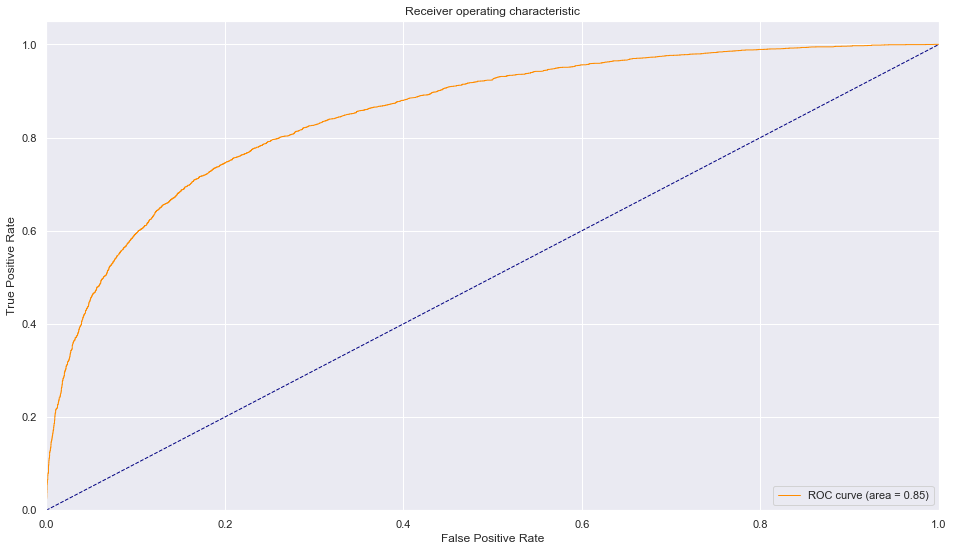

In [371]:
eval_func(y_test,xgb_pred_proba[:,0],roc=True)

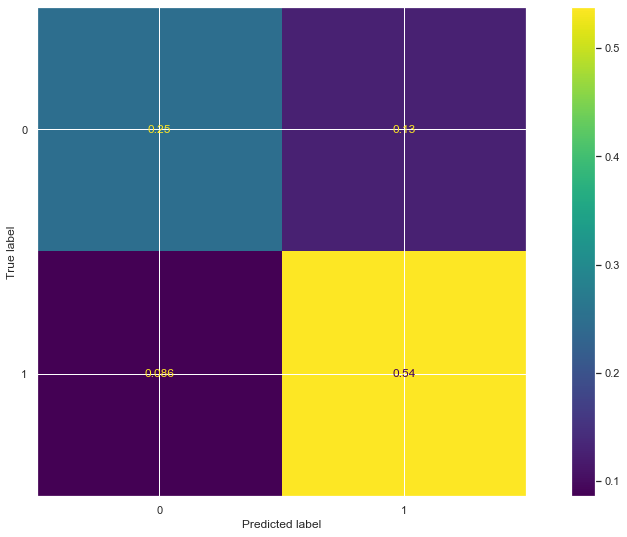

In [380]:
plot_confusion_matrix(estimator=all_models['XGB'],
                      X=X_test,
                      y_true=y_test,
                     normalize='all');

In [420]:
?classification_report

In [422]:
pd.DataFrame(classification_report(y_test,xgb_pred,target_names = ['retained_0','retained_1'],output_dict=True))

,retained_0,retained_1,accuracy,macro avg,weighted avg
f1-score,0.700520,0.834846,0.7871,0.767683,0.784326
precision,0.743728,0.808930,0.7871,0.776329,0.784407
recall,0.662058,0.862478,0.7871,0.762268,0.787100
support,3761.000000,6239.000000,0.7871,10000.000000,10000.000000


In [410]:
import shap

In [412]:
explainer= shap.TreeExplainer(all_models['XGB'].best_estimator_)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [413]:
shap_values = explainer.shap_values(X_test)

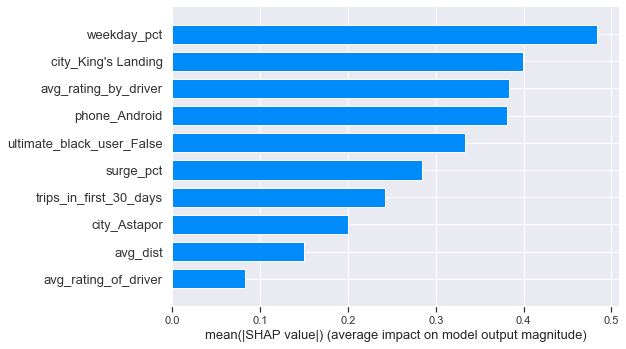

In [418]:
shap.summary_plot(shap_values,X_test,max_display=10,plot_type='bar')

To improve longterm rider retention, Ultimate might want to focus on the top predictors of model performance:

1. **Weekday_pct**: Since weekday commuters are more likely to be retained. An campaign could be launched to encourage non-weekend users to use the service more on the weekdays and that would result in the users to be retained more.

2. **city_King's_Landing**: This indicates that riders from King's Landing tend to be retained more. It is possible that something is happening in other cities with drivers or users that is not properly incentivizing retention.

3. **avg_rating_driver**: This would mean the users not being rated well by the drivers arent being retained. The interaction between the driver and the user could be improved further.